In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
(X_train, y_train) , (X_test, y_test) = keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
print(len(X_train))
print(len(X_test))

60000
10000


In [4]:
X_train[0].shape

(28, 28)

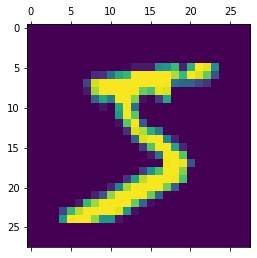

In [5]:
plt.matshow(X_train[0])

In [6]:
y_train[0]

5

In [7]:
X_train = X_train / 255
X_test = X_test / 255

In [8]:
X_train_flattened = X_train.reshape(len(X_train), 28*28)
X_test_flattened = X_test.reshape(len(X_test), 28*28)

In [9]:
X_train_flattened.shape

(60000, 784)

In [10]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2826 - accuracy: 0.9189
Epoch 2/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1258 - accuracy: 0.9628
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0890 - accuracy: 0.9734
Epoch 4/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0690 - accuracy: 0.9792
Epoch 5/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0541 - accuracy: 0.9832


In [11]:
model.evaluate(X_test,y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0769 - accuracy: 0.9760


[0.0768844410777092, 0.9760000109672546]

In [12]:
model.save("./saved_model/")

In [13]:
converter = tf.lite.TFLiteConverter.from_saved_model("./saved_model")
tflite_model = converter.convert()

In [14]:
converter = tf.lite.TFLiteConverter.from_saved_model("./saved_model")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

In [27]:
len(tflite_model)

319748

In [28]:
len(tflite_quant_model)

84616

In [29]:
with open("tflite_model.tflite", "wb") as f:
    f.write(tflite_model)

In [30]:
with open("tflite_quant_model.tflite", "wb") as f:
    f.write(tflite_quant_model)

In [19]:
!pip install tensorflow_model_optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 238 kB 5.3 MB/s 


In [35]:
import tensorflow_model_optimization as tfmot

quantized_model = tfmot.quantization.keras.quantize_model

# q_aware stands for quantization aware.
q_aware_model = quantized_model(model)

# `quantize_model` requires a recompile.
q_aware_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

q_aware_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer_2 (QuantizeL  (None, 28, 28)           3         
 ayer)                                                           
                                                                 
 quant_flatten (QuantizeWrap  (None, 784)              1         
 perV2)                                                          
                                                                 
 quant_dense (QuantizeWrappe  (None, 100)              78505     
 rV2)                                                            
                                                                 
 quant_dense_1 (QuantizeWrap  (None, 10)               1015      
 perV2)                                                          
                                                                 
Total params: 79,524
Trainable params: 79,510
Non-traina

In [36]:
q_aware_model.fit(X_train, y_train, epochs=1)

1875/1875 [==============================] - 11s 5ms/step - loss: 0.0464 - accuracy: 0.9857


In [23]:
q_aware_model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0805 - accuracy: 0.9753


[0.08051393181085587, 0.9753000140190125]

In [24]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_qaware_model = converter.convert()

/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [33]:
len(tflite_quant_model)

84616

In [34]:
len(tflite_qaware_model)

82464

In [26]:
with open("tflite_qaware_model.tflite", 'wb') as f:
    f.write(tflite_qaware_model)